### . 구글 drive와 colab 연동하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/data/딥러닝

/content/drive/MyDrive/data/딥러닝


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## [1] 데이터셋의 이해

- 구글검색 'pfcn 데이터셋'  을 검색하고 pfcn 자료에 대하여 정리하세요


## [2] 자료 로딩 및 검수

### 1-1. pfcn_small.npz 파일 읽기


In [6]:
data=np.load('pfcn_small.npz')
print(list(data))
train_images = data['train_images']   # y값이 될 이미지
test_images = data['test_images']     # y값 이미지


['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [10]:
# 주석작성 - print shape 에  대한 해석
# y_train 에 100*75모양의 컬러사진 1700 장
# y_test 에 100*75모양의 컬러사진 300 장

print('y train=>',np.shape(train_images))

print('y test=>',np.shape(test_images))

y train=> (1700, 100, 75, 3)
y test=> (300, 100, 75, 3)


In [12]:
# 주석작성 - 아래 작업을 왜 하는지
# 스케일링 여부 확인

print('----------train data-----------')
print(train_images.min(), train_images.max())

print('----------test data-----------')
print(test_images.min(), test_images.max())



----------train data-----------
0.0 1.0
----------test data-----------
0.0 1.0


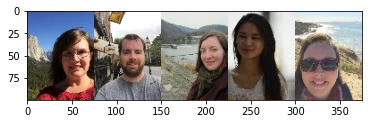

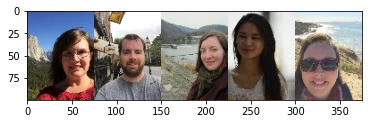

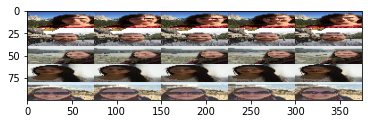

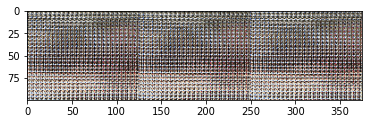

In [13]:
# 주석작성 -  아래 코드의 기능에 대하여 설명

# 사진을 이어붙여서 본다
# trin image[:5]의 shape는  5 100 75 3 인데 traspose를 통해 인덱스를 바꾼뒤 reshape해 볼수 있다
# 즉 100 5 75 3 의경우 100 5*75 3 의 모양으로 이어붙였을때의 크기와 같이 나온다
# 3번째의 경우로 보면 사진이 가로가아닌 세로로 연결됨을 볼 수 있다
# 4번째의 경우 transpose 순서가 바뀌어 이상하게 나옴을 볼 수 있다

plt.imshow(np.hstack(train_images[:5]))
plt.show()
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((100, -1, 3)))
plt.show()
plt.imshow(train_images[:5].reshape((100, 375, 3)))
plt.show()
plt.imshow(train_images[:5].transpose((2,1,0,3)).reshape((100, -1, 3)))
plt.show()

## [3] x데이터 제작 및 모델링

In [16]:
# 주석작성 아래 코드에 대한 설명
# color를 rgb2gray를 통해 흑백으로 바꾸는 코드(train data 제작)
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


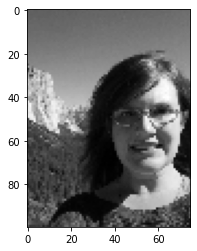

In [25]:
plt.imshow(train_gray_images[0].reshape(100,75),cmap='gray')

In [29]:
show_gray_img = train_gray_images.reshape(-1,100,75)

In [32]:
show_gray_img.shape

(1700, 100, 75)

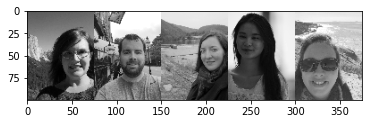

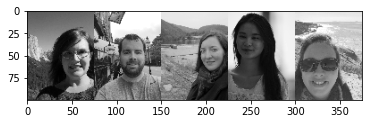

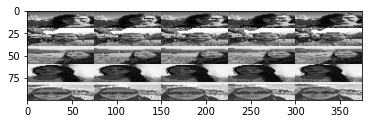

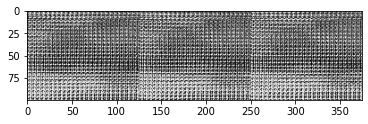

In [34]:
# 작업- 아래의 출력물과 같이 train_gray_images도 위의 컬러 자료와 같이 출력 


plt.imshow(np.hstack(show_gray_img[:5]),cmap='gray')
plt.show()
plt.imshow(show_gray_img[:5].transpose((1,0,2)).reshape((100, -1)),cmap='gray')
plt.show()
plt.imshow(show_gray_img[:5].reshape((100, 375)),cmap='gray')
plt.show()
plt.imshow(show_gray_img[:5].transpose((2,1,0)).reshape((100, -1)),cmap='gray')
plt.show()

In [35]:
# 주석 작성- 아래 코드에 대하여 설명, summary 했을때 결과값의  Output Shape 의 숫자 계산하면 좋음
# 오토인코더형태를 사용?


from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [36]:
# 위자료와 param및 shape 갯수 맞는지 확인
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [37]:
# 주석작성 텐서플로우의 optimizer 의 종류와 특성 간단하게
# 1. 경사 하강법(Gradient Descent)   -> 기울기계산 
# 2. 확률적 경사 하강법(Stochastic Gradient Descent, SGD) -> 경사하강법데이터를 확률적으로 읽어 빠르게
# 3. Nesterov Accelerated Gradient (NAG)  --> 일단 움직이고, 스텝계산
# 4. Adam  --> RMSprop + momentum
# 5. AdaGrad  --> 조금씩 이동
# 6. RMSProp  --> 전에 상황보면서 이동
# 7. AdaMax  --> 
# 8. Nadam --> adam에 모멘텀대신 nag 붙임

model.compile(loss = "mse", optimizer="adam", metrics=["accuracy"])

In [38]:
# 주석작성: verbose 옵션값의 차이
# 0은 진행률 안보임, 1은 defalut 한줄정도, 2는 자세히


hist = model.fit(train_gray_images, train_images, validation_data=(test_gray_images, test_images), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 41s 144ms/step - loss: 0.0222 - accuracy: 0.4705 - val_loss: 0.0671 - val_accuracy: 0.6892
Epoch 2/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0113 - accuracy: 0.5985 - val_loss: 0.0680 - val_accuracy: 0.6892
Epoch 3/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0097 - accuracy: 0.6204 - val_loss: 0.0614 - val_accuracy: 0.6892
Epoch 4/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0090 - accuracy: 0.6304 - val_loss: 0.0541 - val_accuracy: 0.6892
Epoch 5/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0087 - accuracy: 0.6419 - val_loss: 0.0450 - val_accuracy: 0.6892
Epoch 6/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0083 - accuracy: 0.6420 - val_loss: 0.0334 - val_accuracy: 0.6723
Epoch 7/50
54/54 [==============================] - 6s 115ms/step - loss: 0.0079 - accuracy: 0.6315 - val_loss: 0.0257 - val_accuracy: 0.6798
Epoch

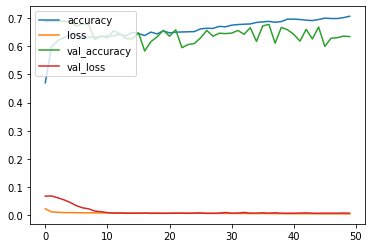

In [39]:

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [40]:
# 주석작성:아래 코드 설명
# 테스트 흑백사진을 model에 넣어 예상함, 예상한 그림의 shape와 테스트 사진의 shape를 비교하여 흑백에서 컬러로 됬는지 확인
res = model.predict(test_gray_images[1:2])
print(test_gray_images[1:2].shape)
print(res.shape)


(1, 100, 75, 1)
(1, 100, 75, 3)


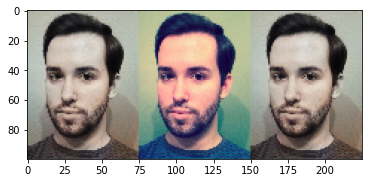

In [41]:
# 주석작성: 코드설명
# 컬러로 바꾼 이미지 사이에 진짜 컬러사진
plt.imshow(np.concatenate([res[0], test_images[1], model.predict(test_gray_images[1:2])[0]], axis=1))

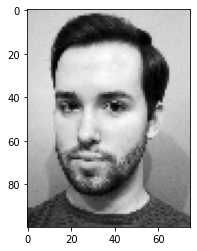

In [ ]:
# 주석작성: 코드설명
# 컬러화 하기전 흑백사진
plt.imshow(test_gray_images[1][...,0], cmap="gray")

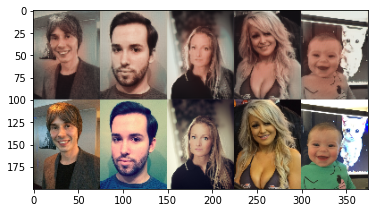

In [ ]:
# 결과 확인
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))

## [4] lab 칼라 모델링
- lab 칼라에 대하여 조사하세요

In [42]:
# 주석작성: 코드 설명
# rgb2lab을통해 rgb 를 lab형태로 변경
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [45]:
train_lab_images.shape

(1700, 100, 75, 3)

In [ ]:
# 주석작성: 코드설명
# lab 형태의 색깔에 최대치. 최소치
print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 100.0
-78.53736435567544 86.20773183914271
-91.97308466277427 93.80664030542576


In [ ]:
# 주석작성: 코드설명
# 첫번째 사진의 색 최대치 최소치
a = train_lab_images + [0, 128, 128]
print(a[...,0].min(), a[...,0].max())
print(a[...,1].min(), a[...,1].max())
print(a[...,2].min(), a[...,2].max())

b = a / [100., 255., 255.]
print(b[...,0].min(), b[...,0].max())
print(b[...,1].min(), b[...,1].max())
print(b[...,2].min(), b[...,2].max())



0.0 100.0
49.462635644324564 214.2077318391427
36.02691533722573 221.80664030542576
0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


In [ ]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

In [ ]:
print(train_lab_images[...,0].min(), train_lab_images[...,0].max())
print(train_lab_images[...,1].min(), train_lab_images[...,1].max())
print(train_lab_images[...,2].min(), train_lab_images[...,2].max())


0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


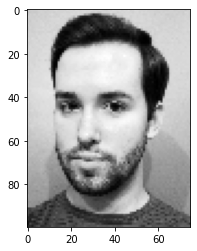

In [51]:
# 주석작성: 코드설명
# 모르겠습니다.
plt.imshow(test_lab_images[1][...,0], cmap="gray")
plt.show()     



### 과제내용은 위에서 끝임. 지금부터는 내용확인만 하세요.
-  lab 칼라 첫번째 채널로 나머지 2채널을 예측하는 모델입니다.

In [ ]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [ ]:
model2 = unet_lab()
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 100, 75, 16)  160         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 100, 75, 16)  64          conv2d_187[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 100, 75, 16)  0           batch_normalization_182[0][0]    
____________________________________________________________________________________________

In [ ]:

model2.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

In [ ]:

hist = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:], validation_data=(test_lab_images[...,0:1], test_lab_images[...,1:]), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 57ms/step - loss: 0.0898 - accuracy: 0.5519 - val_loss: 0.1665 - val_accuracy: 0.4765
Epoch 2/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0358 - accuracy: 0.5887 - val_loss: 0.0403 - val_accuracy: 0.5922
Epoch 3/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0343 - accuracy: 0.5997 - val_loss: 0.0749 - val_accuracy: 0.5536
Epoch 4/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0340 - accuracy: 0.5921 - val_loss: 0.0565 - val_accuracy: 0.5837
Epoch 5/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0336 - accuracy: 0.6058 - val_loss: 0.0520 - val_accuracy: 0.5705
Epoch 6/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0341 - accuracy: 0.6098 - val_loss: 0.0438 - val_accuracy: 0.5907
Epoch 7/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0330 - accuracy: 0.6115 - val_loss: 0.0359 - val_accuracy: 0.5992
Epoch 8/50
54

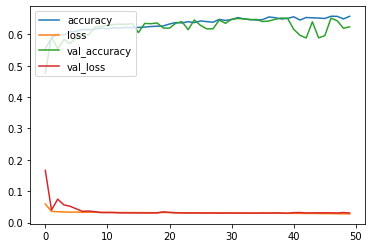

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:

res = model2.predict(test_lab_images[1:2][...,0:1])

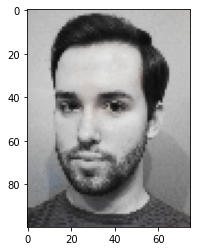

In [ ]:

def l2rgb(l):
    pred_ab = model2.predict(np.expand_dims(l, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = l.reshape((100,75))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


plt.imshow(  l2rgb(test_lab_images[1][...,0]) )

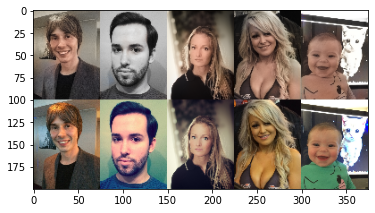

In [ ]:


five = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))


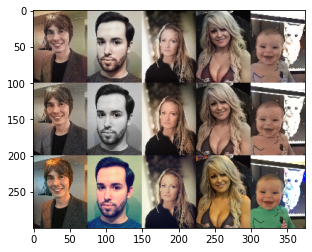

In [ ]:
five1 = model.predict(test_gray_images[:5])
five2 = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five1, five2, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((300, -1,3)))

In [ ]:
loss, acc = new_model.evaluate(test_lab_images[...,0], test_lab_images[...,1:], verbose=1)
print(loss, acc)

10/10 [==============================] - 1s 19ms/step - loss: 0.0306 - accuracy: 0.6238
0.030649233609437943 0.6237773299217224
